**Author :** Hope Townsend

### Metaplot of relative locations of bidirectionals within genes

In [1]:
library(data.table)
library(stringr)
library(ggplot2)
library(cowplot)
library(tidyverse)
library(pheatmap)
library(scales)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.2.1     ✔ purrr   1.0.2
✔ tidyr   1.3.0     ✔ dplyr   1.1.2
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [24]:
genome="hg38"
#genome="mm10"

In [3]:
## setting up visual parameters
ru_color = "gray65"
cowplot_theme = 24

In [4]:
# functions to save images
save_image_png <- function(x, filename, width=NULL, height=NULL) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   png(filename, width=width, height=height, units="in", res=100)
   grid::grid.newpage()
   grid::grid.draw(x)
   dev.off()
}
save_image_pdf <- function(x, filename, width=NULL, height=NULL) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x)
   dev.off()
}

## 0. Remove the TSS bidirectionals of smaller isoforms from overlapping the longer isoforms


### A. Read in data
* Overlaps (variable = overlaps): 
    * results from bedtools intersect of the bidirectionals with RefSeq transcripts
* TSS Bidirectionals (variable = tss): 
    * produced from "Get_bid_TSSs.ipynb" notebook
* Long Isoforms (variable = long):
    * the longest transcript for each gene (based on RefSeq annotation)

In [25]:
# read in the overlaps of all transcripts
if (genome=="hg38") {
overlaps <- fread("overlaps_full_bids_qc_gc_len_posneg_gene_filt_08_14_2023.bed")
colnames(overlaps) <- c("Gene_chr", "Gene_start", "Gene_stop", "TranscriptID", "score", "strand", 
                      "Bid_chr", "Bid_start", "Bid_end", "BidID", 
                      "overlap")
# get the geneid
overlaps$GeneID <- str_split_fixed(overlaps$TranscriptID, ":", 2)[,1]
overlaps[1:2,]
# get list of TSS bidirectionals
tss <- fread("../data/processed_annotations/hg38/tss_bids_08-14-23.txt")
dim(tss)
tss[1:2,]
    } else {
    overlaps <- fread("overlaps_mm10_full_bids_08-27-23.bed")
colnames(overlaps) <- c("Gene_chr", "Gene_start", "Gene_stop", "TranscriptID", "score", "strand", 
                      "Bid_chr", "Bid_start", "Bid_end", "BidID", 
                      "overlap")
# get the geneid
overlaps$GeneID <- str_split_fixed(overlaps$TranscriptID, ":", 2)[,1]
overlaps[1:2,]
# get list of TSS bidirectionals
tss <- fread("../data/processed_annotations/mm10/mm10_tss_bids_08-27-23.txt")
dim(tss)
tss[1:2,]
    }

chr,TranscriptID,strand,GeneID,BidID,Frac_TSS_overlap,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>
chr1,MIR6859-1:NR_106918.1,-,MIR6859-1,chr1-17453-17621-tfit,0.28000,0.99408,17537,17436,101
chr1,LOC127239154:NR_182074.1,-,LOC127239154,chr1-297077-297529-dreg,0.54167,0.71744,297303,297504,201


### Separate overlaps of TSS bids 

In [26]:
# separate overlaps into those invovling TSS bidirecitonals and those not
tss_overlaps <- overlaps[overlaps$BidID %in% tss$BidID,]
nrow(tss_overlaps)
nontss_overlaps <- overlaps[!overlaps$BidID %in% tss$BidID,]
nrow(nontss_overlaps)
nrow(tss_overlaps) + nrow(nontss_overlaps) == nrow(overlaps)

[1] 89814

[1] 2337208

[1] TRUE

### Of overlaps w/ TSS bids, only keep overlap if between Transcript & its identified TSS bid

In [27]:
## === FUNCTIONS
# function that will return TRUE if a TSS Bid is assigned to the transcript isoform provided
isIsoformsTSS <- function(TSS_bid, transcript) {
    # get all transcripts that TSS_bid is assigned to
    assigned_transcripts <- tss[tss$BidID == TSS_bid,]$TranscriptID
    # return TRUE if transcript is in it
    transcript %in% assigned_transcripts
    }
# test (only works for hg38 genome)
isIsoformsTSS("chr1-297077-297529-dreg", "LOC127239154:NR_182074.1") # TRUE
isIsoformsTSS("chr1-17453-17621-tfit", "LOC127239154:NR_182074.1") # FALSE
# list comprehension of tss overlaps
tss_overlaps[1:2,]
bool_IsoformsTSS <- map2(tss_overlaps[1:2,]$BidID, tss_overlaps[1:2,]$TranscriptID, isIsoformsTSS)
tss[tss$TranscriptID %in% tss_overlaps[1:2,]$TranscriptID,]
bool_IsoformsTSS # should be FALSE, TRUE based on above

[1] TRUE

[1] FALSE

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,overlap,GeneID
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>
chr1,14361,29370,WASH7P:NR_024540.1,.,-,chr1,17453,17621,chr1-17453-17621-tfit,168,WASH7P
chr1,262718,297504,LOC127239154:NR_182074.1,.,-,chr1,297077,297529,chr1-297077-297529-dreg,427,LOC127239154


chr,TranscriptID,strand,GeneID,BidID,Frac_TSS_overlap,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>
chr1,LOC127239154:NR_182074.1,-,LOC127239154,chr1-297077-297529-dreg,0.54167,0.71744,297303,297504,201


[[1]]
[1] FALSE

[[2]]
[1] TRUE

In [28]:
# Run on full list
bool_IsoformsTSS <- map2(tss_overlaps$BidID, tss_overlaps$TranscriptID, isIsoformsTSS)
length(bool_IsoformsTSS)
# add as mark for tss_overlaps
tss_overlaps$bool_IsoformTSS <- bool_IsoformsTSS

[1] 89814

In [29]:
# only keep TSS overlaps where the proper match is made (bool=TRUE)
tss_overlaps[1:2,]
nrow(tss_overlaps)
tss_overlaps2 <- tss_overlaps[tss_overlaps$bool_IsoformTSS == "TRUE",]
nrow(tss_overlaps2)
nrow(tss_overlaps) - nrow(tss_overlaps2)
(nrow(tss_overlaps) - nrow(tss_overlaps2))/nrow(overlaps)*100

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,overlap,GeneID,bool_IsoformTSS
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<list>
chr1,14361,29370,WASH7P:NR_024540.1,.,-,chr1,17453,17621,chr1-17453-17621-tfit,168,WASH7P,FALSE
chr1,262718,297504,LOC127239154:NR_182074.1,.,-,chr1,297077,297529,chr1-297077-297529-dreg,427,LOC127239154,TRUE


[1] 89814

[1] 55921

[1] 33893

[1] 1.396485

In [30]:
# Recombine the filtered overlaps 
orig <- nrow(overlaps)
orig
nontss_overlaps$bool_IsoformTSS <- rep(NA, nrow(nontss_overlaps))
overlaps <- rbind(tss_overlaps2[], nontss_overlaps)
nrow(overlaps)
orig - nrow(overlaps) == 33893 # human
orig - nrow(overlaps) == 38733 # mouse

[1] 2427022

[1] 2393129

[1] TRUE

[1] FALSE

## 1. Normalize bidirectional locations to percentage location of gene

### Test of pipeline to get the percentile based coordinates of bidirectionals within genes

In [31]:
# practice df to make sure I'm doing what I think I'm doing
test <- data.frame(data.table("chr"=c(1,1,1,1), 
                                  "Gene_start"=c(90, 90, 90, 90), 
                                  "Gene_stop"=c(500, 500, 500, 500), 
                                  "TranscriptID"=c("Gene+", "Gene+", "Gene-", "Gene-"), 
                                  "strand"=c("+", "+", "-", "-"), 
                                  "Bid_start"=c(80, 490, 80, 490), "Bid_end"=c(100, 510, 100, 510)))

# == Get the length (Ref gene end) & size factors of genes
test$Ref_Gene_end <- test$Gene_stop - test$Gene_start
test$sizefactor <- 100/(test$Ref_Gene_end+1)

# == Get the coordinates of bidirectionals in reference to TSS of gene
pos_test <- test[test$strand == "+",]
neg_test <- test[test$strand == "-",]

pos_test$Ref_Bid_start = pos_test$Bid_start - pos_test$Gene_start
pos_test$Ref_Bid_end = pos_test$Bid_end - pos_test$Gene_start
pos_test$Ref_Bid_mid = (pos_test$Ref_Bid_start + pos_test$Ref_Bid_end)/2

# Negative (Bid side closest to gene start will be end so make start end & opp)
neg_test$Ref_Bid_end = neg_test$Gene_stop - neg_test$Bid_start 
neg_test$Ref_Bid_start = neg_test$Gene_stop - neg_test$Bid_end 
neg_test$Ref_Bid_mid = (neg_test$Ref_Bid_start + neg_test$Ref_Bid_end)/2

# == Get the coordinates of bidirectionals as percentiles of gene
pos_test$Norm_Bid_start = round(pos_test$Ref_Bid_start*pos_test$sizefactor)
pos_test$Norm_Bid_end = round(pos_test$Ref_Bid_end*pos_test$sizefactor)
pos_test$Norm_Bid_mid = round(pos_test$Ref_Bid_mid*pos_test$sizefactor)

neg_test$Norm_Bid_start = round(neg_test$Ref_Bid_start*neg_test$sizefactor)
neg_test$Norm_Bid_end = round(neg_test$Ref_Bid_end*neg_test$sizefactor)
neg_test$Norm_Bid_mid = round(neg_test$Ref_Bid_mid*neg_test$sizefactor)

pos_test
neg_test

,chr,Gene_start,Gene_stop,TranscriptID,strand,Bid_start,Bid_end,Ref_Gene_end,sizefactor,Ref_Bid_start,Ref_Bid_end,Ref_Bid_mid,Norm_Bid_start,Norm_Bid_end,Norm_Bid_mid
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,90,500,Gene+,+,80,100,410,0.243309,-10,10,0,-2,2,0
2,1,90,500,Gene+,+,490,510,410,0.243309,400,420,410,97,102,100


,chr,Gene_start,Gene_stop,TranscriptID,strand,Bid_start,Bid_end,Ref_Gene_end,sizefactor,Ref_Bid_end,Ref_Bid_start,Ref_Bid_mid,Norm_Bid_start,Norm_Bid_end,Norm_Bid_mid
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1,90,500,Gene-,-,80,100,410,0.243309,420,400,410,97,102,100
4,1,90,500,Gene-,-,490,510,410,0.243309,10,-10,0,-2,2,0


### A. Get the Length (Reference end) & sizefactor for each gene

In [32]:
# get the length of the gene as the standardized end
overlaps$Ref_Gene_end <- overlaps$Gene_stop - overlaps$Gene_start
# create a size factor
overlaps$sizefactor <- 100/(overlaps$Ref_Gene_end+1)
overlaps[1:2,]

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,overlap,GeneID,bool_IsoformTSS,Ref_Gene_end,sizefactor
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<list>,<int>,<dbl>
chr1,262718,297504,LOC127239154:NR_182074.1,.,-,chr1,297077,297529,chr1-297077-297529-dreg,427,LOC127239154,TRUE,34786,0.002874637
chr1,725758,778634,LOC100288069:NR_168328.1,.,-,chr1,778597,778849,"chr1-778597-778849-tfit,dreg",37,LOC100288069,TRUE,52876,0.001891181


### B. Change the bidirectional locations in reference to TSS of gene

In [33]:
# split the posiitiive and negative genes
pos_overlaps <- overlaps[overlaps$strand == "+",]
neg_overlaps <- overlaps[overlaps$strand == "-",]

In [34]:
# Change the bid locations in reference to start
#   Pos strand gene Gene start = Gene_start (leftmost)
pos_overlaps$Ref_Bid_start = pos_overlaps$Bid_start - pos_overlaps$Gene_start
pos_overlaps$Ref_Bid_end = pos_overlaps$Bid_end - pos_overlaps$Gene_start
pos_overlaps$Ref_Bid_mid = (pos_overlaps$Ref_Bid_start + pos_overlaps$Ref_Bid_end)/2
#   Neg strand gene Gene start = Gene_stop (rightmost)
#   To ensure Bids are still closest to start to farthest oriented: (Bid side closest to gene start will be end so make start end & opp)
neg_overlaps$Ref_Bid_end = neg_overlaps$Gene_stop - neg_overlaps$Bid_start 
neg_overlaps$Ref_Bid_start = neg_overlaps$Gene_stop - neg_overlaps$Bid_end 
neg_overlaps$Ref_Bid_mid = (neg_overlaps$Ref_Bid_start + neg_overlaps$Ref_Bid_end)/2

### C. Standardize the bid locations as percentiles of the total gene (start & stop)

In [35]:
# multiply all positions by the size factor
pos_overlaps$Norm_Bid_start = round(pos_overlaps$Ref_Bid_start*pos_overlaps$sizefactor)
pos_overlaps$Norm_Bid_end = round(pos_overlaps$Ref_Bid_end*pos_overlaps$sizefactor)
pos_overlaps$Norm_Bid_mid = round(pos_overlaps$Ref_Bid_mid*pos_overlaps$sizefactor)

neg_overlaps$Norm_Bid_start = round(neg_overlaps$Ref_Bid_start*neg_overlaps$sizefactor)
neg_overlaps$Norm_Bid_end = round(neg_overlaps$Ref_Bid_end*neg_overlaps$sizefactor)
neg_overlaps$Norm_Bid_mid = round(neg_overlaps$Ref_Bid_mid*neg_overlaps$sizefactor)

In [36]:
# combine the pos & neg overlaps again
overlaps <- rbind(pos_overlaps, neg_overlaps)
dim(overlaps)
overlaps[1:2,]

[1] 2393129      21

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,⋯,GeneID,bool_IsoformTSS,Ref_Gene_end,sizefactor,Ref_Bid_start,Ref_Bid_end,Ref_Bid_mid,Norm_Bid_start,Norm_Bid_end,Norm_Bid_mid
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<chr>,<list>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,817370,819834,FAM87B:NR_103536.1,.,+,chr1,817274,817686,chr1-817274-817686-dreg,⋯,FAM87B,TRUE,2464,0.04056795,-96,316,110,-4,13,4
chr1,960583,965719,KLHL17:NM_198317.3,.,+,chr1,960443,960679,"chr1-960443-960679-tfit,dreg",⋯,KLHL17,TRUE,5136,0.01946661,-140,96,-22,-3,2,0


## 2. Graph the Standardized Locations
* Note about Warning messages: The warning messages are because I cut off certain x values as evident by the fact that there are no NA or infinite values in what is being graphed

In [37]:
any(is.na(overlaps$Norm_Bid_start))
any(is.na(overlaps$Norm_Bid_end))
any(is.na(overlaps$Norm_Bid_mid))

any(is.infinite(overlaps$Norm_Bid_start))
any(is.infinite(overlaps$Norm_Bid_end))
any(is.infinite(overlaps$Norm_Bid_mid))

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

Warning message:
“Removed 1064 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 553 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 342 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


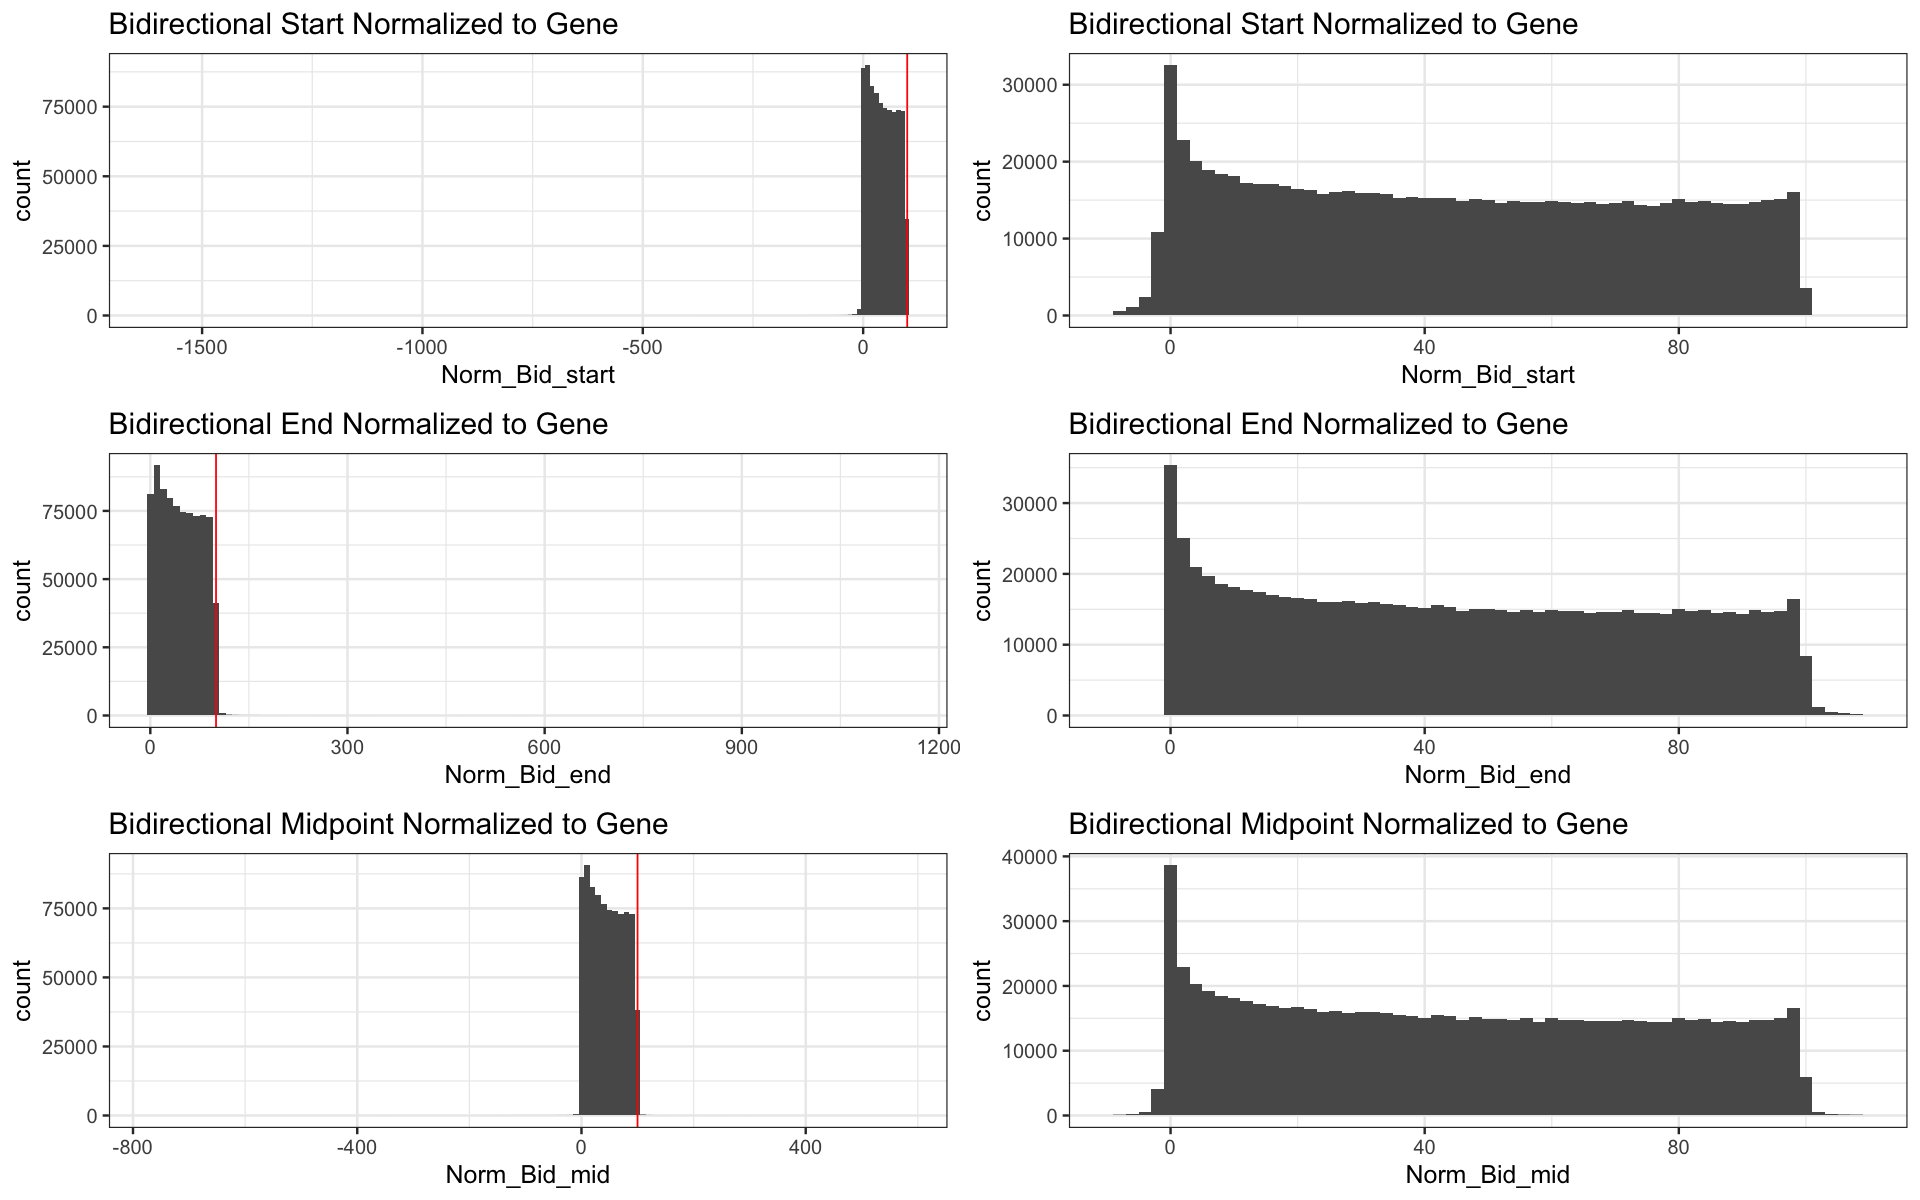

In [18]:
# Grpah the locations
p1 <- ggplot(overlaps, aes(x=Norm_Bid_start)) + geom_histogram(binwidth=10) + theme_bw(base_size=15) +
ggtitle("Bidirectional Start Normalized to Gene")+ geom_vline(xintercept=100, color="red")
p1b <- ggplot(overlaps, aes(x=Norm_Bid_start)) + geom_histogram(binwidth=2) + theme_bw(base_size=15) +
ggtitle("Bidirectional Start Normalized to Gene") + xlim(-10, 110)
p2 <- ggplot(overlaps, aes(x=Norm_Bid_end)) + geom_histogram(binwidth=10) + theme_bw(base_size=15) +
ggtitle("Bidirectional End Normalized to Gene")+ geom_vline(xintercept=100, color="red")
p2b <- ggplot(overlaps, aes(x=Norm_Bid_end)) + geom_histogram(binwidth=2) + theme_bw(base_size=15) +
ggtitle("Bidirectional End Normalized to Gene") + xlim(-10, 110)
p3 <- ggplot(overlaps, aes(x=Norm_Bid_mid)) + geom_histogram(binwidth=10) + theme_bw(base_size=15) +
ggtitle("Bidirectional Midpoint Normalized to Gene") + geom_vline(xintercept=100, color="red")
p3b <- ggplot(overlaps, aes(x=Norm_Bid_mid)) + geom_histogram(binwidth=2) + theme_bw(base_size=15) +
ggtitle("Bidirectional Midpoint Normalized to Gene") + xlim(-10, 110)
options(repr.plot.height = 10, repr.plot.width =16 )
plot_grid(p1, p1b, p2, p2b, p3, p3b,  nrow=3)

In [38]:
# get the proper annotation locations
if (genome == "hg38") {yannot=45000} else {yannot=15000}

[1] 0

[1] 100

Warning message:
“Removed 572 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 572 rows containing non-finite values (`stat_density()`).”


pdf 
  2

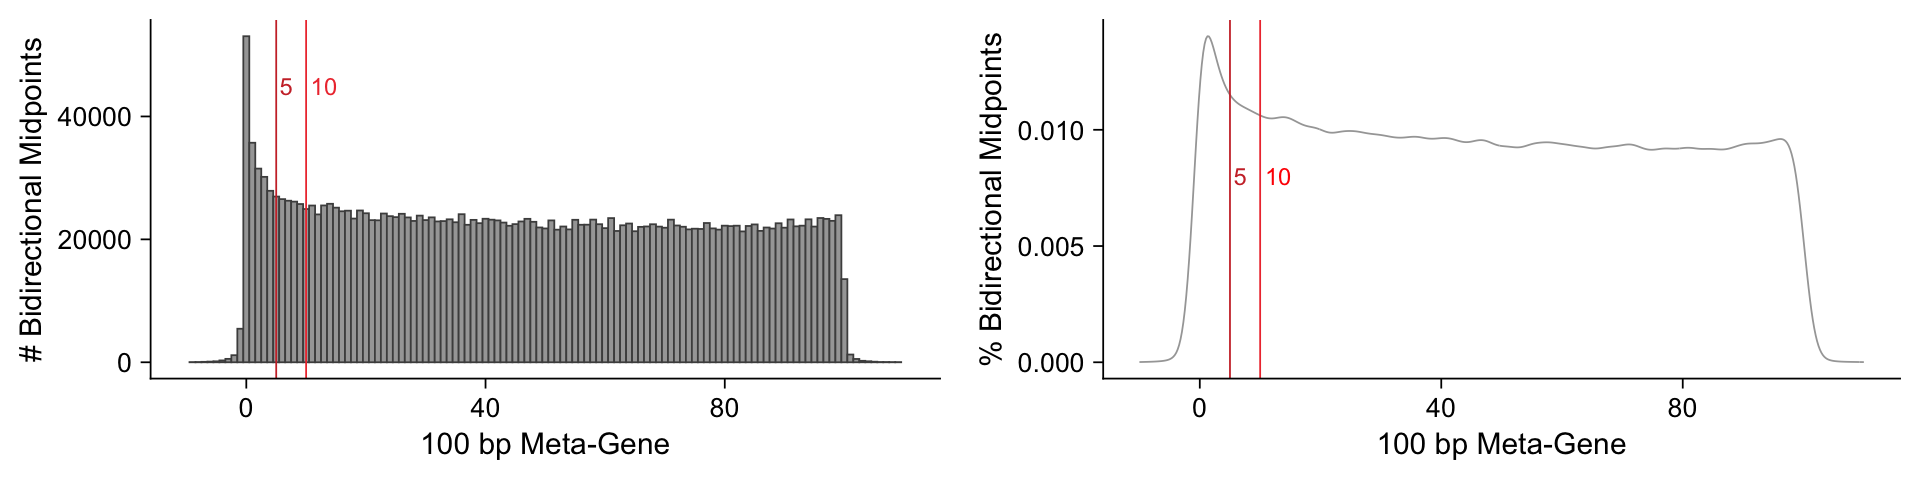

In [39]:
color5 = "brown3"
color10 = "brown2"
p1 <- ggplot(overlaps, aes(x=Norm_Bid_mid)) + geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
#ggtitle("                                               Bidirectional Midpoint Normalized to Gene (-10% to 110%)") + 
xlim(-10, 110) + labs(x="100 bp Meta-Gene",y="# Bidirectional Midpoints") +
geom_vline(xintercept=5, color=color5) + annotate("text", x=6.7, y=yannot, label="5", color=color5, size=5) + 
geom_vline(xintercept=10, color=color10) + annotate("text", x=13, y=yannot, label="10", color=color10, size=5) + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 28), 
      axis.title = element_text(size = 18), 
      axis.text = element_text(size = 16))
use <- overlaps[overlaps$Norm_Bid_mid > -0.5 & overlaps$Norm_Bid_mid < 100.5,]
min(use$Norm_Bid_mid)
max(use$Norm_Bid_mid)

p3 <- ggplot(overlaps, aes(x=Norm_Bid_mid)) + xlim(-10, 110) +
geom_density(color=ru_color) + theme_cowplot(cowplot_theme) + 
geom_vline(xintercept=5, color=color5) + annotate("text", x=6.7, y=0.008, label="5", color=color5, size=5) + 
geom_vline(xintercept=10, color=color10) + annotate("text", x=13, y=0.008, label="10", color="red", size=5) +
labs(x="100 bp Meta-Gene", y="% Bidirectional Midpoints") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 28), 
      axis.title = element_text(size = 18), 
      axis.text = element_text(size = 16))

options(repr.plot.height = 4, repr.plot.width =16 )
save <- plot_grid(p1, p3)
save
save_image_png(save, paste0("./figures/", genome, "Norm_Bid_mid_histogram.png"), width=16, height=4)

[1] "HG38 Bidirectional Midpoint Normalized to Gene"


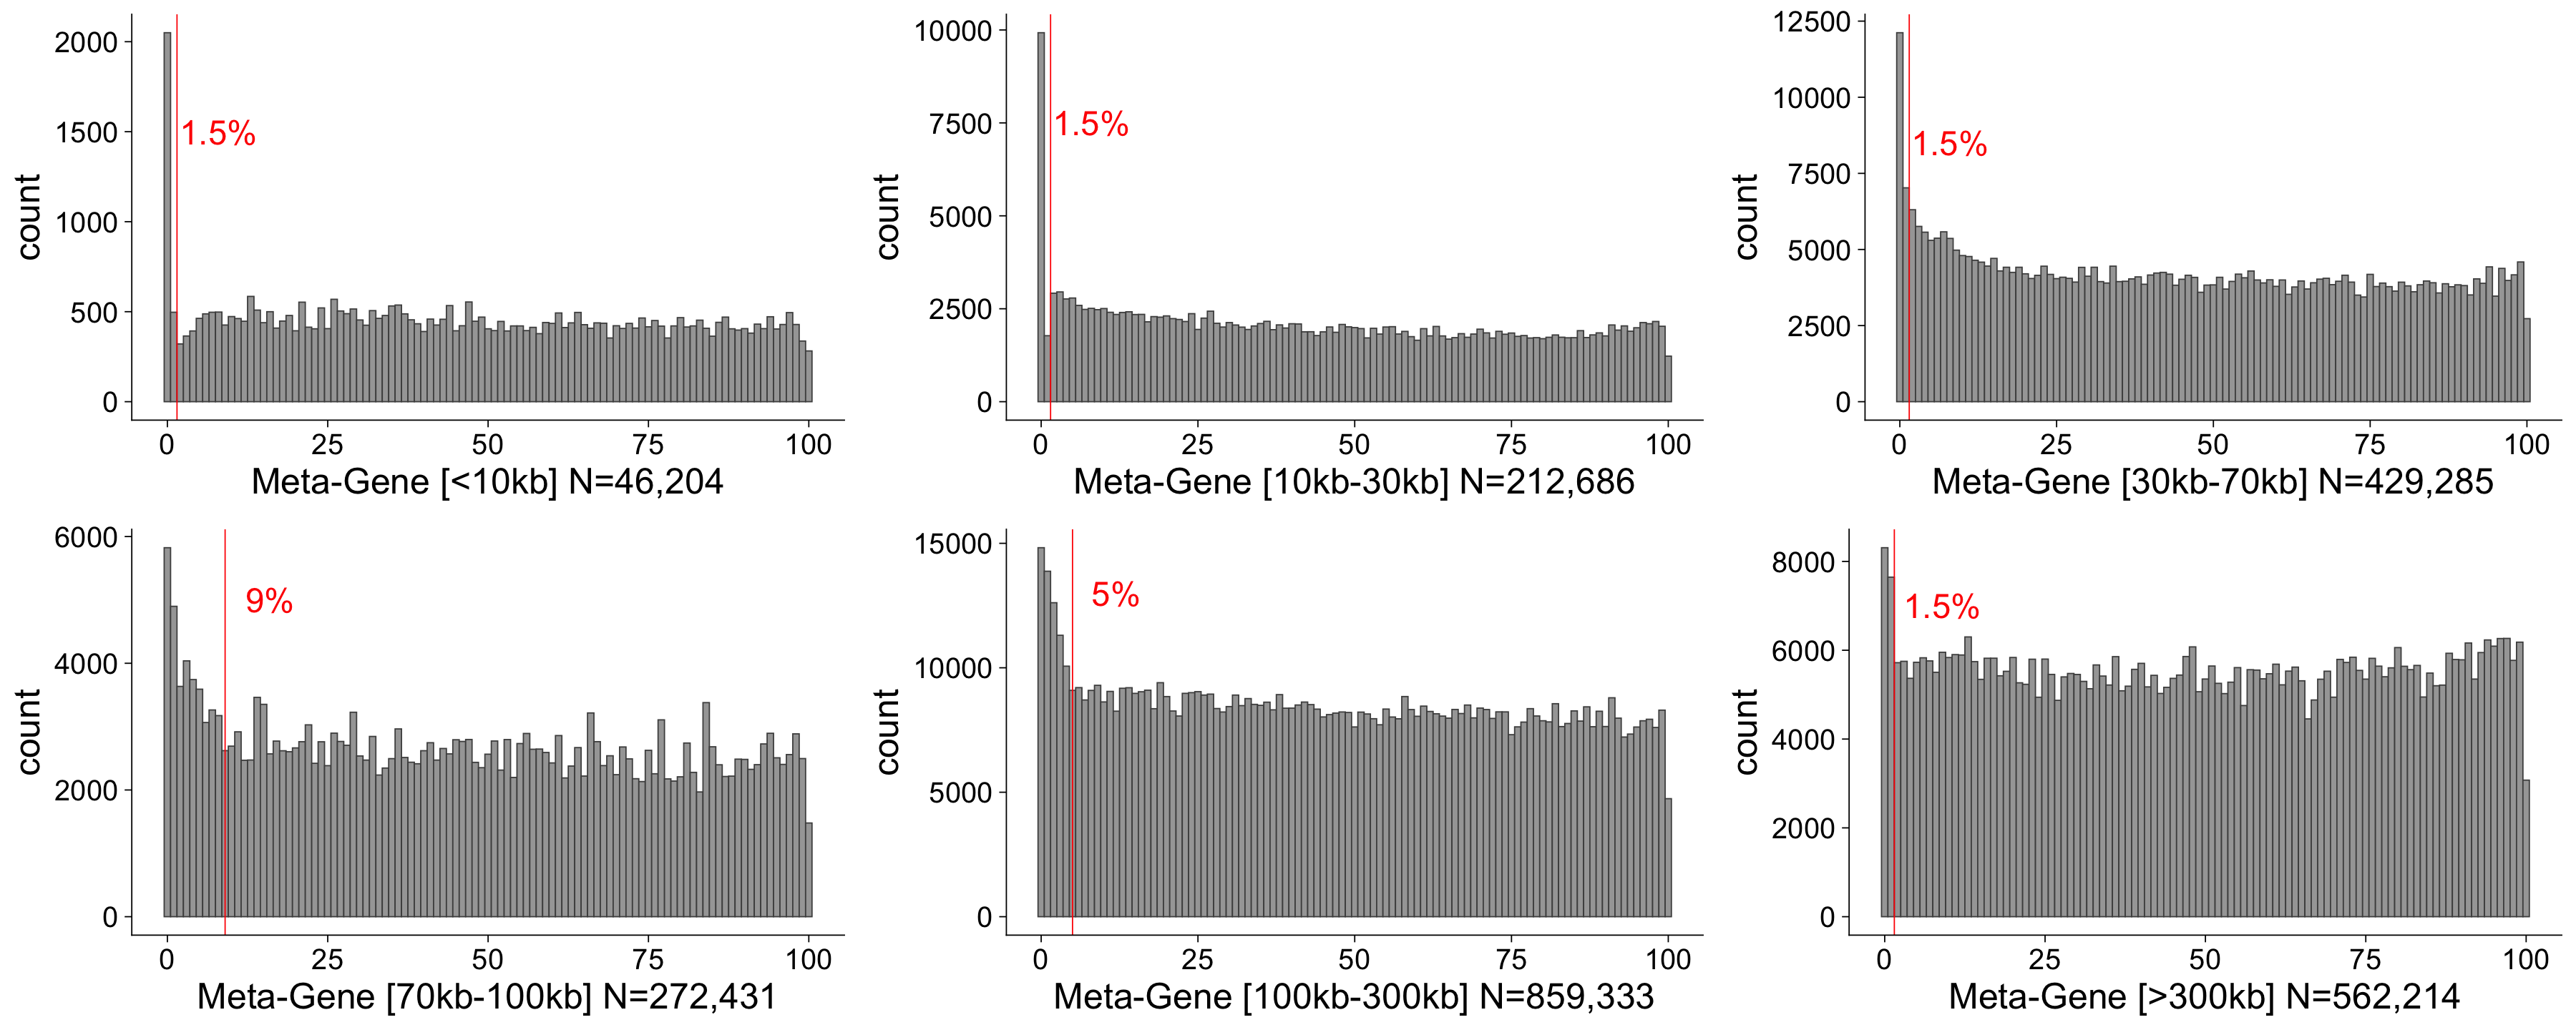

In [40]:
## FOR HG38 (annotation numbers)
graphing <- use[use$Ref_Gene_end<10000]
print("HG38 Bidirectional Midpoint Normalized to Gene")
p1 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=1500, label="1.5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [<10kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=10000 & use$Ref_Gene_end<30000]
p2 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=7500, label="1.5%", color="red", size=10) +
labs(x=paste0("Meta-Gene [10kb-30kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=30000 & use$Ref_Gene_end<70000]
p3 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=8500, label="1.5%", color="red", size=10) +
labs(x=paste0("Meta-Gene [30kb-70kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=70000 & use$Ref_Gene_end<100000]
p4 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=9, color="red") + annotate("text", x=16, y=5000, label="9%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [70kb-100kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=100000 & use$Ref_Gene_end<300000]
p5 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=5, color="red") + annotate("text", x=12, y=13000, label="5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [100kb-300kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=300000]
p6 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=9, y=7000, label="1.5%", color="red", size=10) +
labs(x=paste0("Meta-Gene [>300kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")
options(repr.plot.height = 12, repr.plot.width =30 )
save <- plot_grid(p1, p2, p3, p4, p5, p6, nrow=2)
save
ggsave(save, width = 30, height = 12,
       filename = paste0("./paper_figures/", genome, "_Norm_Bid_mid_histogram_genelengthbins.pdf"), 
       bg = "transparent")
#save_image_png(save, "./paper_figures/Norm_Bid_mid_histogram_genelengthbins.png", width=25, height=8)

[1] "HG38 Bidirectional Midpoint Normalized to Gene"


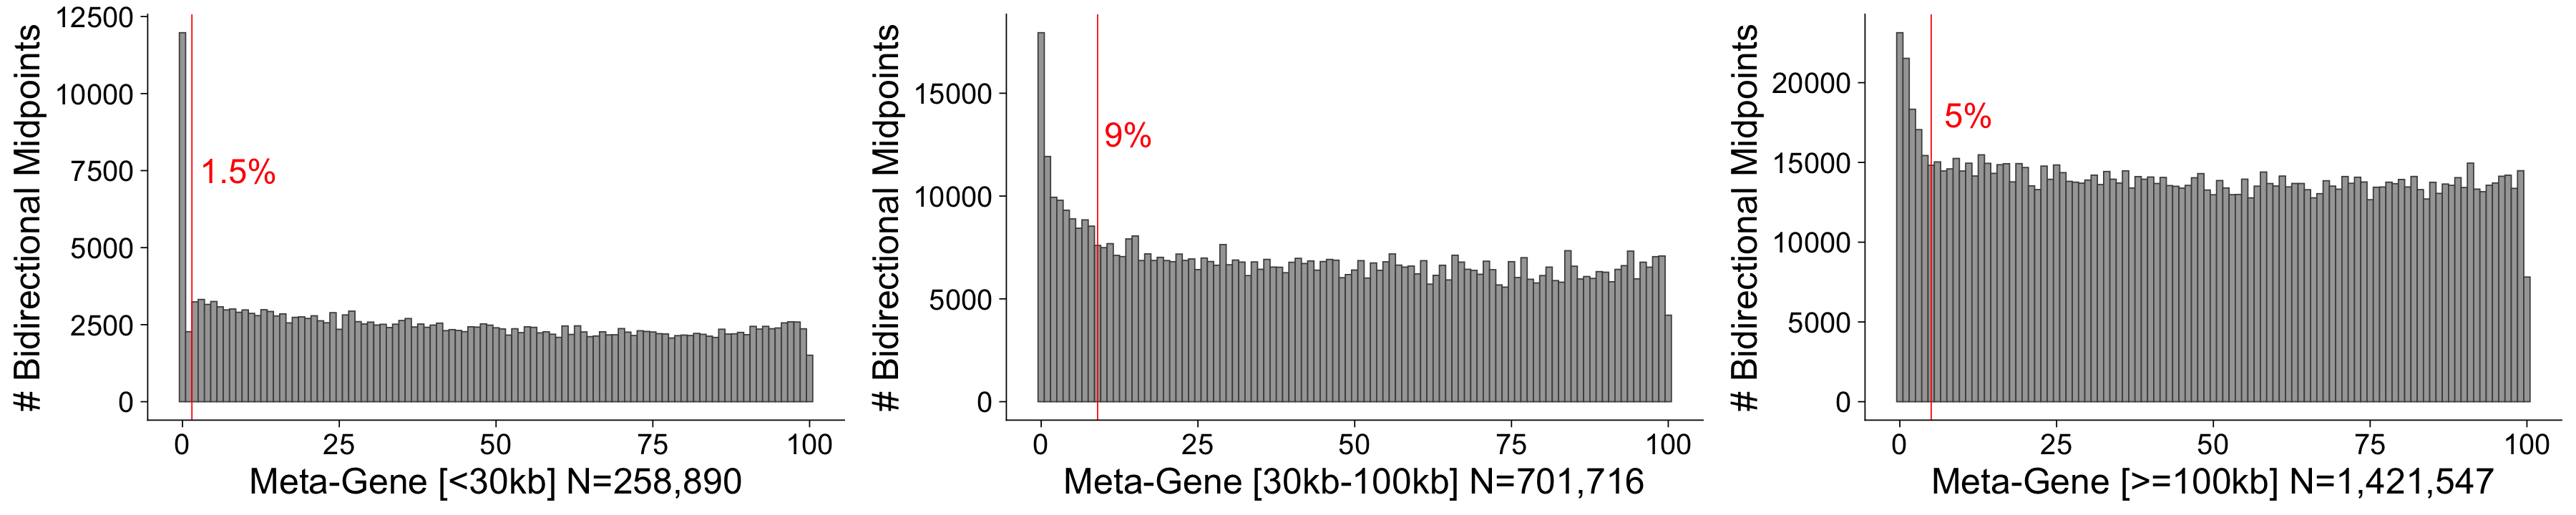

In [41]:
## FOR HG38 (annotation numbers)
graphing <- use[use$Ref_Gene_end<30000]
print("HG38 Bidirectional Midpoint Normalized to Gene")
p1 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=9, y=7500, label="1.5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [<30kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")


graphing <- use[use$Ref_Gene_end>=30000 & use$Ref_Gene_end<100000]
p3 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=9, color="red") + annotate("text", x=14, y=13000, label="9%", color="red", size=10) +
labs(x=paste0("Meta-Gene [30kb-100kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")


graphing <- use[use$Ref_Gene_end>=100000,]
p5 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=5, color="red") + annotate("text", x=11, y=18000, label="5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [>=100kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")
options(repr.plot.height = 6, repr.plot.width =30 )
save <- plot_grid(p1,  p3, p5, nrow=1)
save
ggsave(save, width = 30, height = 6,
       filename = paste0("./paper_figures/", genome, "_Norm_Bid_mid_histogram_3genelengthbins.png"), 
       bg = "transparent")
#save_image_png(save, "./paper_figures/Norm_Bid_mid_histogram_genelengthbins.png", width=25, height=8)

[1] "Bidirectional Midpoint Normalized to Gene"


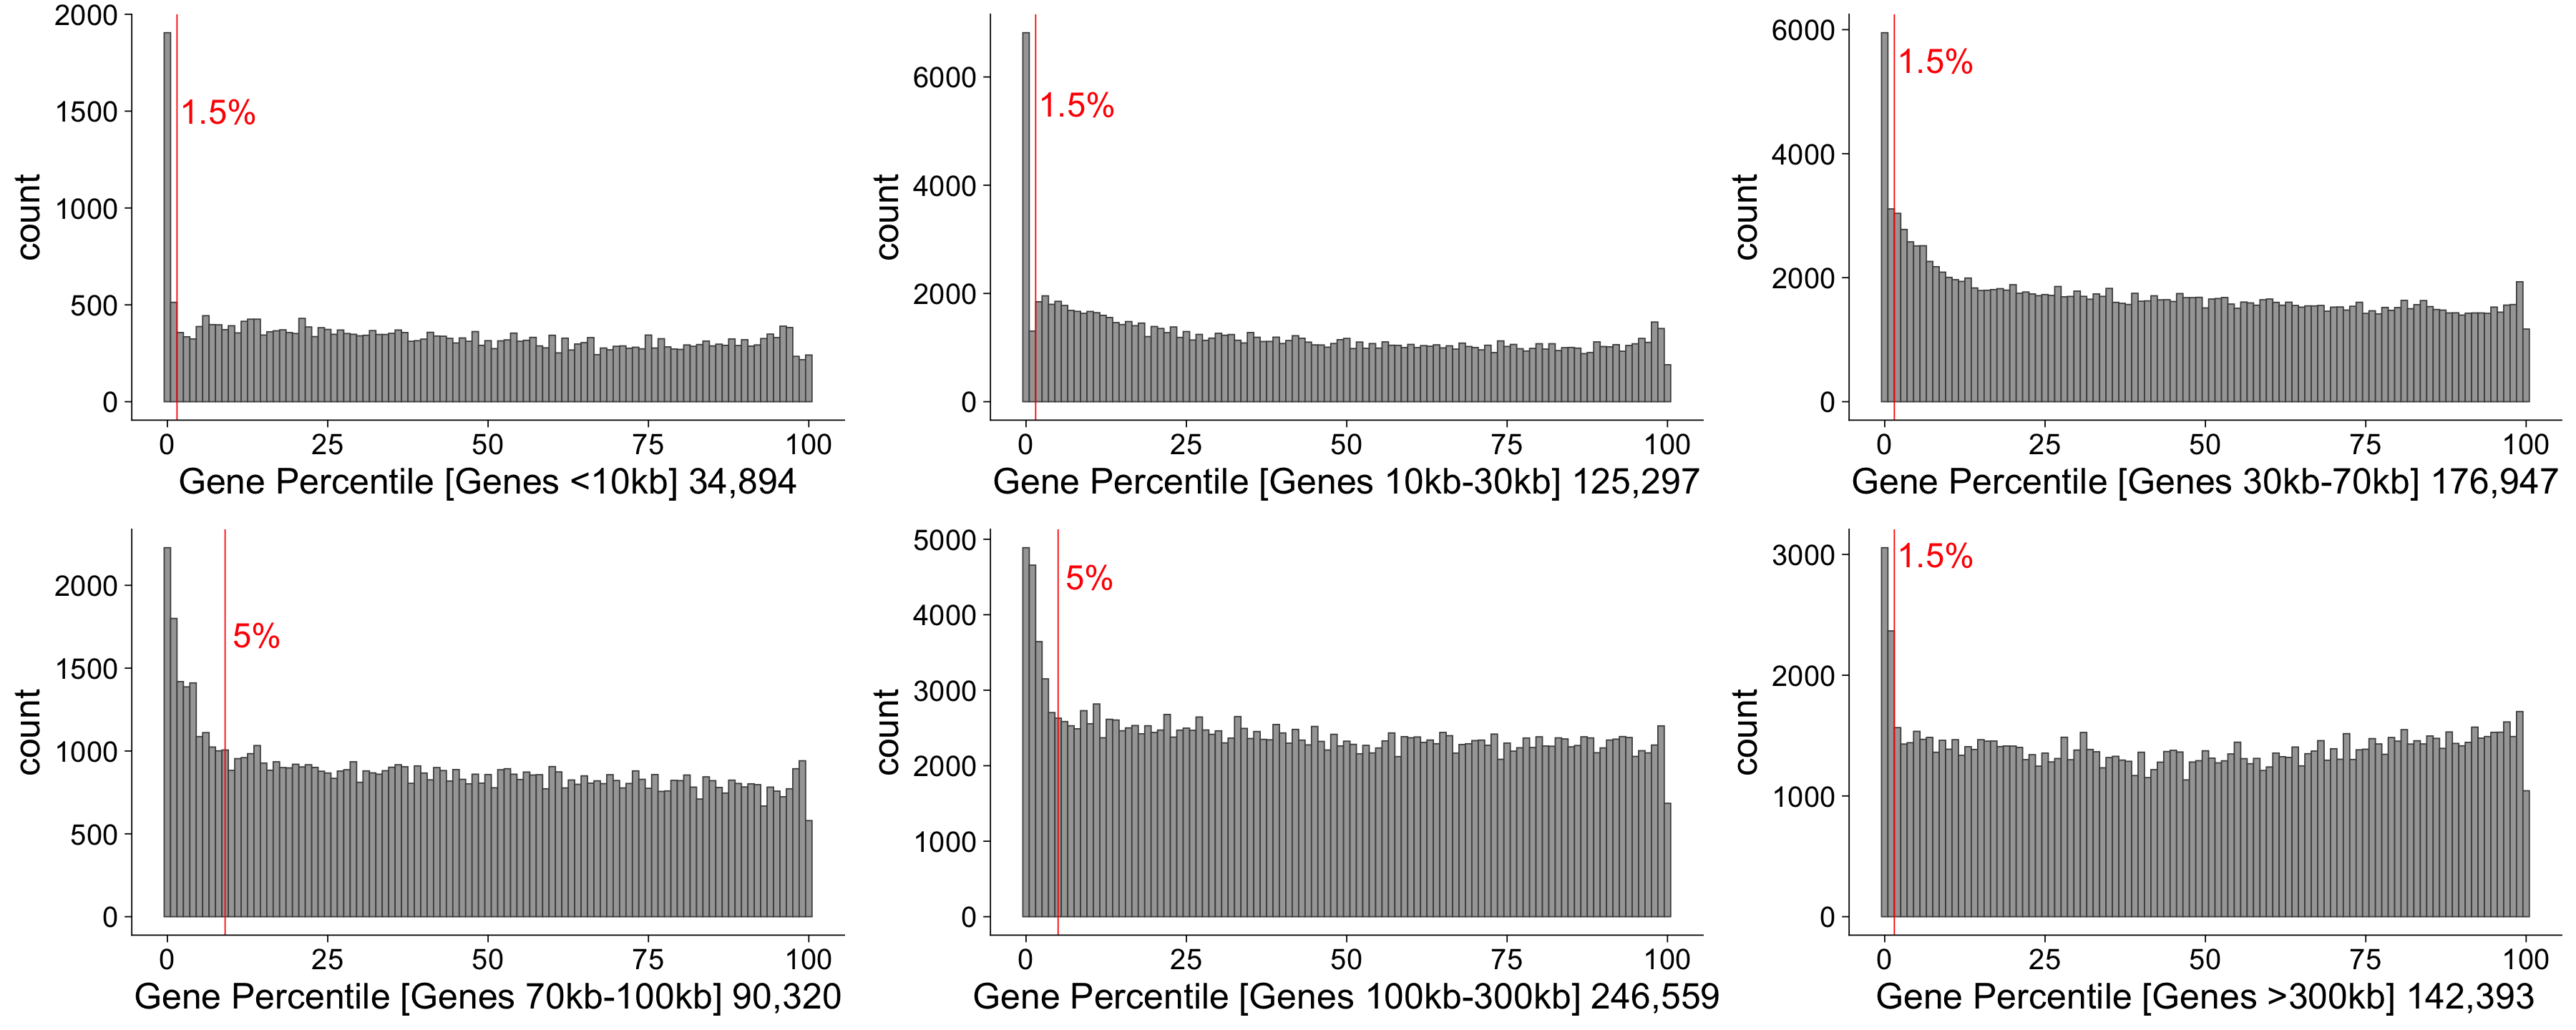

In [23]:
## FOR MM10 (annotation numbers)
graphing <- use[use$Ref_Gene_end<10000]
print("Bidirectional Midpoint Normalized to Gene")
p1 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=1500, label="1.5%", color="red", size=10) +
 labs(x=paste("Gene Percentile [Genes <10kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=10000 & use$Ref_Gene_end<30000]
p2 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=5500, label="1.5%", color="red", size=10) +
labs(x=paste("Gene Percentile [Genes 10kb-30kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=30000 & use$Ref_Gene_end<70000]
p3 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=5500, label="1.5%", color="red", size=10) +
labs(x=paste("Gene Percentile [Genes 30kb-70kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=70000 & use$Ref_Gene_end<100000]
p4 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=9, color="red") + annotate("text", x=14, y=1700, label="5%", color="red", size=10) +
 labs(x=paste("Gene Percentile [Genes 70kb-100kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=100000 & use$Ref_Gene_end<300000]
p5 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=5, color="red") + annotate("text", x=10, y=4500, label="5%", color="red", size=10) +
 labs(x=paste("Gene Percentile [Genes 100kb-300kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=300000]
p6 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=3000, label="1.5%", color="red", size=10) +
labs(x=paste("Gene Percentile [Genes >300kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")
options(repr.plot.height = 12, repr.plot.width =30 )
save <- plot_grid(p1, p2, p3, p4, p5, p6, nrow=2)
save
ggsave(save, width = 30, height = 12,
       filename = paste0("./paper_figures/", genome, "_Norm_Bid_mid_histogram_genelengthbins.pdf"), 
       bg = "transparent")
#save_image_png(save, "./paper_figures/Norm_Bid_mid_histogram_genelengthbins.png", width=25, height=8)

[1] "Bidirectional Midpoint Normalized to Gene"


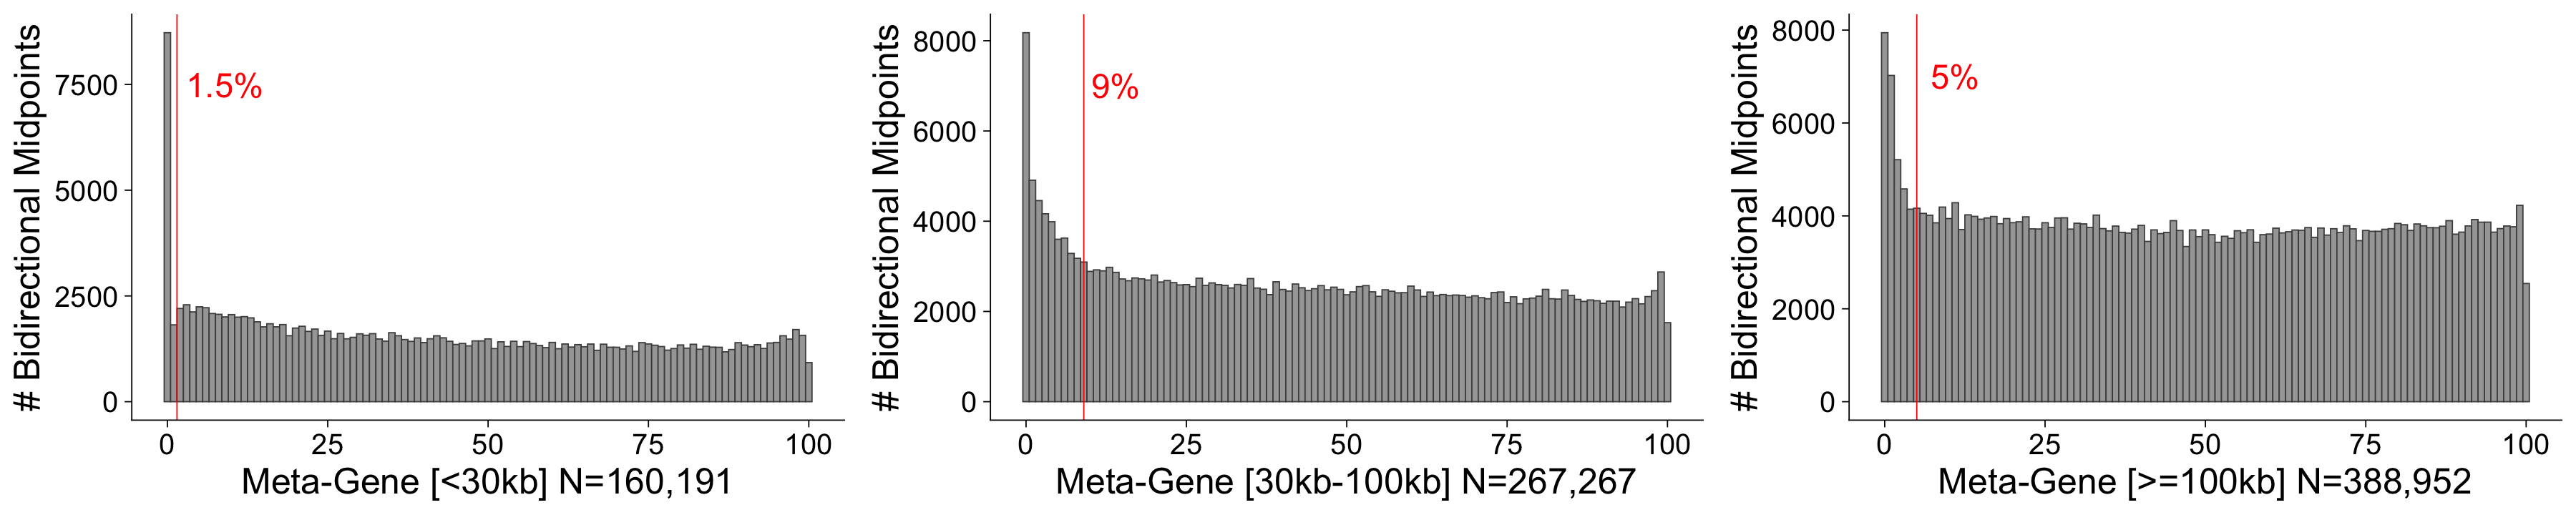

In [ ]:
## FOR MM10 (annotation numbers)
graphing <- use[use$Ref_Gene_end<30000]
print("Bidirectional Midpoint Normalized to Gene")
p1 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=9, y=7500, label="1.5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [<30kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")


graphing <- use[use$Ref_Gene_end>=30000 & use$Ref_Gene_end<100000]
p3 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=9, color="red") + annotate("text", x=14, y=7000, label="9%", color="red", size=10) +
labs(x=paste0("Meta-Gene [30kb-100kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")


graphing <- use[use$Ref_Gene_end>=100000,]
p5 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=5, color="red") + annotate("text", x=11, y=7000, label="5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [>=100kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")
options(repr.plot.height = 6, repr.plot.width =30 )
save <- plot_grid(p1,  p3, p5, nrow=1)
save
ggsave(save, width = 30, height = 6,
       filename = paste0("./paper_figures/", genome, "_Norm_Bid_mid_histogram_3genelengthbins.png"), 
       bg = "transparent")
#save_image_png(save, "./paper_figures/Norm_Bid_mid_histogram_genelengthbins.png", width=25, height=8)